# Controle PID - Motor DC

## Parâmetros e Constantes
- Da caracterização do Motor em Bancada
- Datasheet do Fornecedor (Pololu)

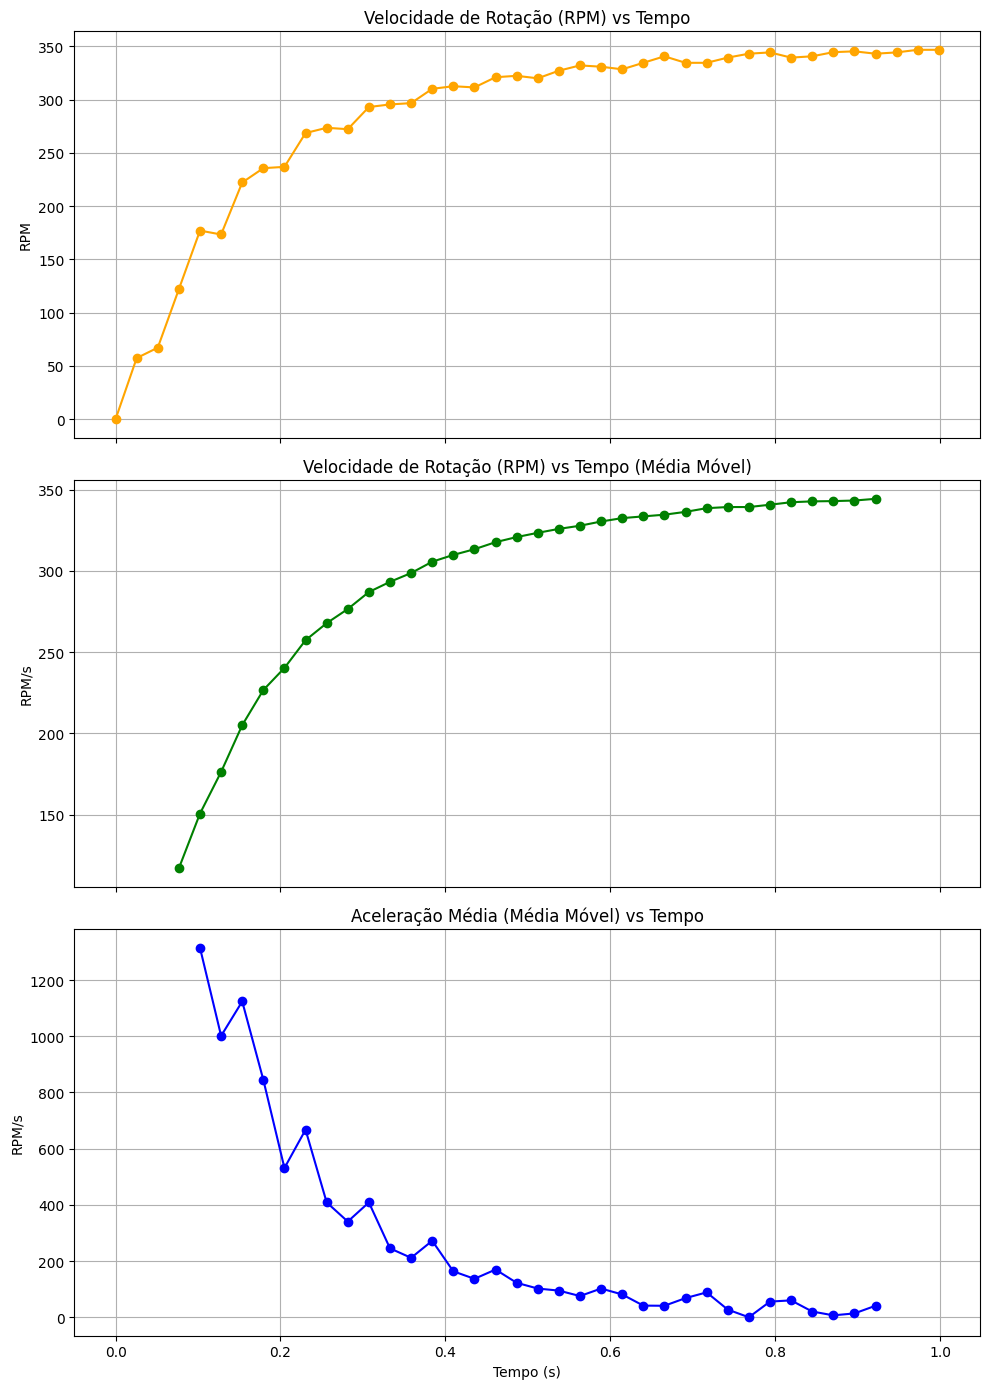

In [1]:
# Caracterização em Bancada
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Dados obtidos na bancada
dados = [
    (0.000000,   0), (0.025600,  47), (0.051201,  55), (0.076800, 100),
    (0.102400, 145), (0.127998, 142), (0.153600, 182), (0.179200, 193),
    (0.204800, 194), (0.230400, 220), (0.255996, 224), (0.281600, 223),
    (0.307200, 240), (0.332800, 242), (0.358400, 243), (0.384000, 254),
    (0.409600, 256), (0.435192, 255), (0.460800, 263), (0.486400, 264),
    (0.511992, 262), (0.537600, 268), (0.563200, 272), (0.588800, 271),
    (0.614400, 269), (0.640000, 274), (0.665600, 279), (0.691200, 274),
    (0.716800, 274), (0.742400, 278), (0.768000, 281), (0.793600, 282),
    (0.819200, 278), (0.844800, 279), (0.870384, 282), (0.896000, 283),
    (0.921600, 281), (0.947200, 282), (0.972800, 284), (0.998400, 284)
]

# Extração de vetores de tempo e pulsos
tempos = np.array([t for t, _ in dados])
pulsos = np.array([p for _, p in dados])

# Cálculo de Δt (diferenças de tempo)
dts = np.diff(tempos, prepend=tempos[0])
if dts[0] == 0:
    dts[0] = dts[1]

# Pulsos por volta
PULSOS_POR_VOLTA = 1920

# Conversão para RPM
rpm = (pulsos / PULSOS_POR_VOLTA) * (60 / dts)

# ----- Aceleração média com média móvel -----
def moving_average(x, window_size):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

window = 7 # número de amostras na média
rpm_ma = moving_average(rpm, window)
tempos_ma = moving_average(tempos, window)
acc_ma = np.diff(rpm_ma) / np.diff(tempos_ma) # Aproximação de aceleração média na janela
temp_acc_ma = tempos_ma[1:]

# ----- Aceleração instantânea -----
acc_raw = np.diff(rpm, prepend=rpm[0]) / dts

# ----- Plot  -----
fig, axs = plt.subplots(3, 1, figsize=(10, 14), sharex=True)

axs[0].plot(tempos, rpm, marker='o', color='orange')
axs[0].set_title('Velocidade de Rotação (RPM) vs Tempo')
axs[0].set_ylabel('RPM')
axs[0].grid(True)

axs[1].plot(tempos_ma, rpm_ma, marker='o', color='green')
axs[1].set_title('Velocidade de Rotação (RPM) vs Tempo (Média Móvel)')
axs[1].set_ylabel('RPM/s')
axs[1].grid(True)

axs[2].plot(temp_acc_ma, acc_ma, marker='o', color='blue')
axs[2].set_title('Aceleração Média (Média Móvel) vs Tempo')
axs[2].set_xlabel('Tempo (s)')
axs[2].set_ylabel('RPM/s')
axs[2].grid(True)

plt.tight_layout()
plt.show()


=== Especificações do Motor ===
Tensão nominal: 12V
Torque de parada: 110 oz-in
Corrente de parada: 5000 mA
Velocidade em vazio: 350 RPM
Corrente em vazio: 300 mA

=== Resultados Calculados ===
Inclinação de TorqueVsCurrent: 42.7273 mA/(oz-in)
Recíproco (Constante de Torque): 0.0234 (oz-in)/mA

Potência mecânica de saída máxima: 7.12 W
Torque para potência máxima: 54.9 oz-in
Corrente para potência máxima: 2645.3 mA

Resistência do motor: 2.40 ohms


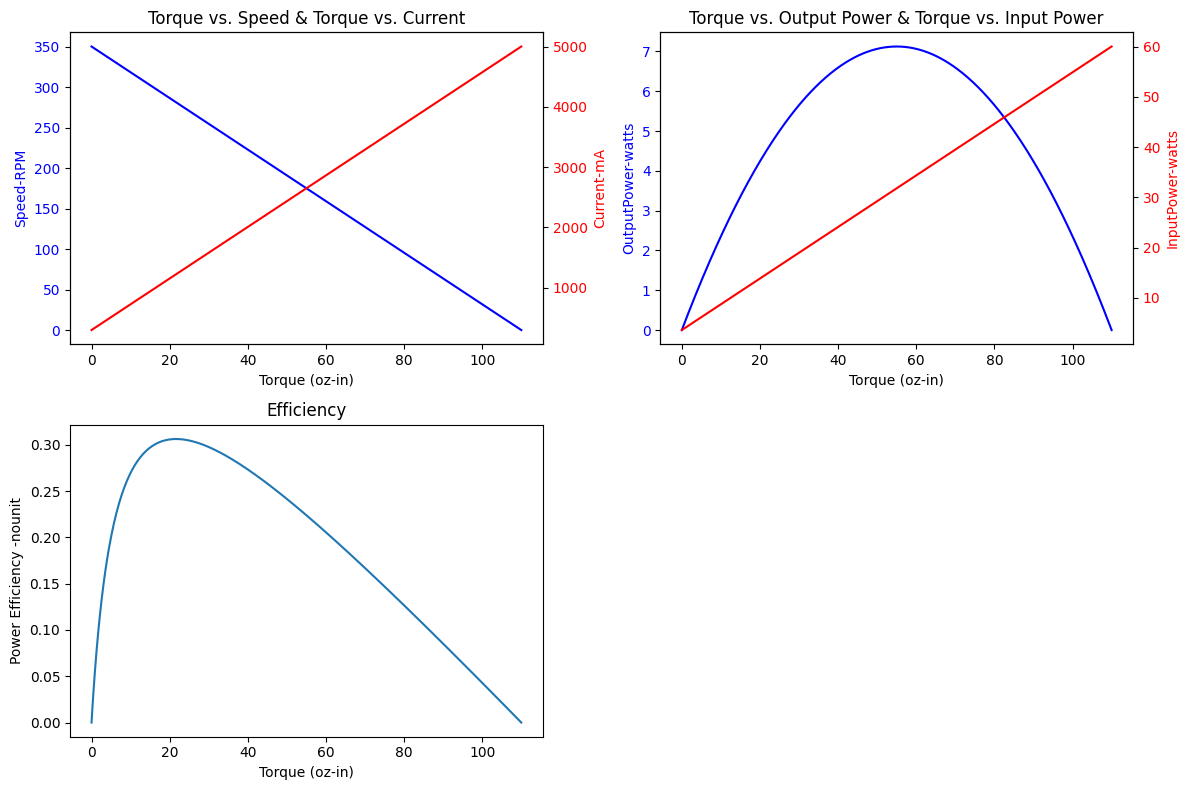

In [2]:
#Datasheet Pololu - Item#1443
import numpy as np
import matplotlib.pyplot as plt

def pololu_motor_plot_gen_aam_v2():
    plt.close('all')
    discrete_bins = 500  # Número de bins para plotagem e cálculos
    
    # Dados do motor conforme a tabela fornecida (usando valores para 12V)
    stall_torque = 110    # oz-in
    stall_current = 5000  # mA
    rated_voltage = 12    # V
    no_load_current = 300 # mA
    no_load_speed = 350   # RPM
    
    # Cálculos básicos
    resistance = rated_voltage / (stall_current / 1000)
    
    # Linhas para plotagem
    torque_line = np.linspace(0, stall_torque, discrete_bins)
    current_line = np.linspace(no_load_current, stall_current, discrete_bins)
    speed_line = np.linspace(no_load_speed, 0, discrete_bins)
    
    # Constante de torque
    slope_torque_vs_current = (stall_current - no_load_current) / stall_torque
    
    # Potências
    output_power = 0.00074 * torque_line * speed_line  # Potência mecânica de saída em watts
    input_power = current_line * rated_voltage / 1000  # Potência elétrica de entrada em watts
    
    # Criando a figura
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Torque vs Velocidade e Torque vs Corrente
    plt.subplot(2, 2, 1)
    ax1 = plt.gca()
    ax1.plot([0, stall_torque], [no_load_speed, 0], 'b-')
    ax1.set_xlabel('Torque (oz-in)')
    ax1.set_ylabel('Speed-RPM', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.plot([0, stall_torque], [no_load_current, stall_current], 'r-')
    ax2.set_ylabel('Current-mA', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    plt.title('Torque vs. Speed & Torque vs. Current')
    
    # Subplot 2: Torque vs Potência de Saída e Torque vs Potência de Entrada
    plt.subplot(2, 2, 2)
    ax3 = plt.gca()
    ax3.plot(torque_line, output_power, 'b-')
    ax3.set_xlabel('Torque (oz-in)')
    ax3.set_ylabel('OutputPower-watts', color='b')
    ax3.tick_params(axis='y', labelcolor='b')
    
    ax4 = ax3.twinx()
    ax4.plot(torque_line, input_power, 'r-')
    ax4.set_ylabel('InputPower-watts', color='r')
    ax4.tick_params(axis='y', labelcolor='r')
    plt.title('Torque vs. Output Power & Torque vs. Input Power')
    
    # Subplot 3: Eficiência de Potência
    plt.subplot(2, 2, 3)
    power_eff = output_power / input_power
    plt.plot(torque_line, power_eff)
    plt.xlabel('Torque (oz-in)')
    plt.ylabel('Power Efficiency -nounit')
    plt.title('Efficiency')
    
    plt.tight_layout()
    
    # Saída de informações
    print("\n=== Especificações do Motor ===")
    print(f"Tensão nominal: {rated_voltage}V")
    print(f"Torque de parada: {stall_torque} oz-in")
    print(f"Corrente de parada: {stall_current} mA")
    print(f"Velocidade em vazio: {no_load_speed} RPM")
    print(f"Corrente em vazio: {no_load_current} mA")
    
    print("\n=== Resultados Calculados ===")
    print(f"Inclinação de TorqueVsCurrent: {slope_torque_vs_current:.4f} mA/(oz-in)")
    print(f"Recíproco (Constante de Torque): {1/slope_torque_vs_current:.4f} (oz-in)/mA")
    
    max_power_idx = np.argmax(output_power)
    print(f"\nPotência mecânica de saída máxima: {output_power[max_power_idx]:.2f} W")
    print(f"Torque para potência máxima: {torque_line[max_power_idx]:.1f} oz-in")
    print(f"Corrente para potência máxima: {current_line[max_power_idx]:.1f} mA")
    print(f"\nResistência do motor: {resistance:.2f} ohms")
    
    plt.show()

# Chamada da função
if __name__ == "__main__":
    pololu_motor_plot_gen_aam_v2()

## Função de Transferência
- Comparando os Resultados obtidos abaixo utilizaremos uma função de 1a Ordem, pois se aproxima da curva de posição real


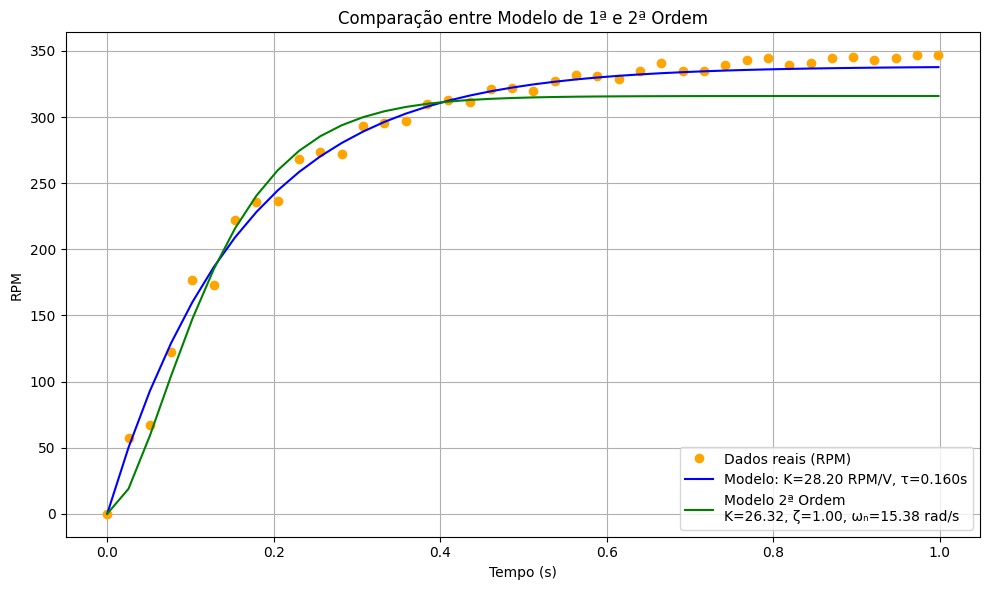

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Modelo exponencial de resposta de 1ª ordem
def modelo_motor(t, K, tau):
    return K * (1 - np.exp(-t / tau))

# Ajuste até ~0.6s (região transitória)
idx_fit = tempos < 0.6
t_fit = tempos[idx_fit]
rpm_fit = rpm[idx_fit]

# Ajuste de curva exponencial
params, _ = curve_fit(modelo_motor, t_fit, rpm_fit, bounds=(0, [1000, 2]))
K_rpm, tau = params

# Normalização por tensão aplicada
rated_voltage = 12  # V
K_rpm_v = K_rpm / rated_voltage

# Modelo com ganho normalizado (RPM/V)
def modelo_normalizado(t, K_v, tau):
    return rated_voltage * K_v * (1 - np.exp(-t / tau))

# Geração da curva teórica
rpm_modelo_1ordem = modelo_normalizado(tempos, K_rpm_v, tau)

def modelo_2ordem(t, K, zeta, omega_n):
    omega_d = omega_n * np.sqrt(1 - zeta**2)
    exp_term = np.exp(-zeta * omega_n * t)
    seno_term = np.sin(omega_d * t)
    cos_term = np.cos(omega_d * t)
    fase_term = (zeta / np.sqrt(1 - zeta**2)) * seno_term
    resposta = K * (1 - exp_term * (cos_term + fase_term))
    return rated_voltage * resposta

# Ajuste do modelo 2ª ordem
initial_guess = [30,1,20]
params_2ordem, _ = curve_fit(modelo_2ordem, t_fit, rpm_fit, p0=initial_guess, bounds=(0, [100, 1, 200]))
K2, zeta2, omega_n2 = params_2ordem
rpm_model_2ordem = modelo_2ordem(tempos, K2, zeta2, omega_n2)

# Plot comparativo
plt.figure(figsize=(10, 6))
plt.plot(tempos, rpm, 'o', label='Dados reais (RPM)', color='orange')
plt.plot(tempos, rpm_modelo_1ordem, '-', label=f'Modelo: K={K_rpm_v:.2f} RPM/V, τ={tau:.3f}s', color='blue')
plt.plot(tempos, rpm_model_2ordem, '-', label=f'Modelo 2ª Ordem\nK={K2:.2f}, ζ={zeta2:.2f}, ωₙ={omega_n2:.2f} rad/s', color='green')
plt.title('Comparação entre Modelo de 1ª e 2ª Ordem')
plt.xlabel('Tempo (s)')
plt.ylabel('RPM')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

$$\frac{28.2}{0.16+s}$$

## Introducao da inercia da carga

--- SISTEMA DE TESTE (EXPERIMENTAL) ---
Inércia do disco de teste: 2.111e-03 kg.m²
Inércia total do teste (Motor + Disco): 2.112e-03 kg.m²
Constante de tempo medida (tau_teste): 0.160 s

--- SISTEMA FINAL (COM CARRETEL E CARGA) ---
Inércia do carretel: 2.188e-05 kg.m²
Inércia refletida da carga: 9.375e-05 kg.m²
Inércia total final: 1.174e-04 kg.m²
Constante de tempo estimada (tau_final): 0.009 s


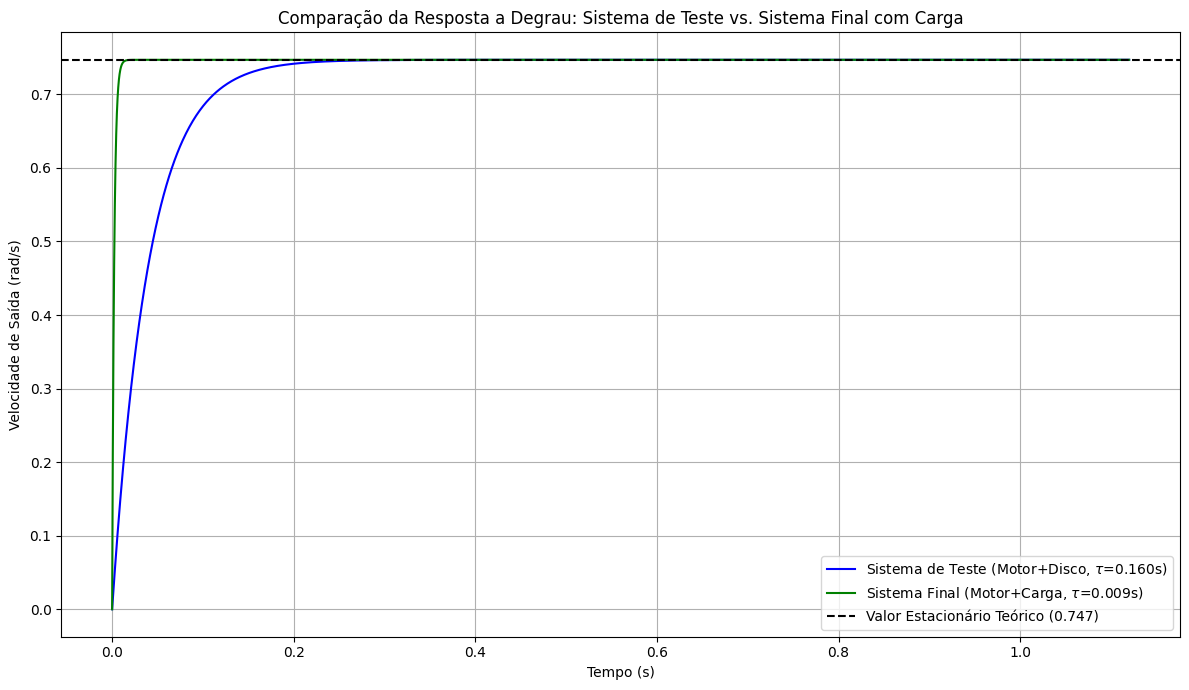


--- Funções de Transferência Finais ---

FT para VELOCIDADE (com carga final):
<TransferFunction>: sys[11]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


    2.953
--------------
0.008889 s + 1


FT para POSIÇÃO (com carga final):
<TransferFunction>: sys[18]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


     2.953
----------------
0.008889 s^2 + s



In [4]:
import numpy as np
import control as co
import matplotlib.pyplot as plt

# --- 1. PARÂMETROS BASE E DADOS EXPERIMENTAIS ---
K_motor_rpm_v = 28.2    # Ganho RPM/V (do ajuste de curva)
# tau_teste é a constante de tempo medida no ensaio com o disco
tau_teste = 0.16        # s 

# Converter ganho para rad/s/V para consistência com unidades SI
K_motor_rad_v = K_motor_rpm_v * (2 * np.pi / 60)

# --- 2. CÁLCULO DAS INÉRCIAS ---

# Inércia do motor (do CAD)
J_motor = 1.7387e-6     # kg.m² 

# Parâmetros do Disco de Teste (usado no ensaio)
raio_disco = 0.05
altura_disco = 0.025    # m (2.5 cm)
densidade = 8600    # kg/m³ (assumindo que o disco é de latao)
volume_disco = np.pi * raio_disco**2 * altura_disco
massa_disco = volume_disco * densidade
J_disco_teste = 0.5 * massa_disco * raio_disco**2 # Inércia de um cilindro sólido

# Inércia total do sistema que foi TESTADO experimentalmente
J_teste = J_motor + J_disco_teste

# Parâmetros da Carga FINAL (carretel + efetuador)
massa_carga_final = 0.15      # kg (efetuador que se move linearmente)
massa_carretel_final = 0.035   # kg (peça que gira com o motor)
raio_carretel_final = 0.025   # m

# Inércia do carretel final (assumido como um anel/cilindro de parede fina)
J_carretel_final_rot = massa_carretel_final * raio_carretel_final**2

# Inércia da carga linear refletida no eixo do motor
J_carga_final_eq = massa_carga_final * raio_carretel_final**2

# Inércia total do sistema FINAL que queremos modelar
J_final = J_motor + J_carretel_final_rot + J_carga_final_eq

# --- 3. CÁLCULO DA NOVA CONSTANTE DE TEMPO PARA O SISTEMA FINAL ---
# A nova constante de tempo é escalonada a partir da experimental com base na razão das inércias
if J_teste > 0:
    tau_final_com_carga = tau_teste * (J_final / J_teste)
else:
    print("Aviso: J_teste é zero, não é possível calcular a nova constante de tempo.")
    tau_final_com_carga = tau_teste # Fallback

# --- Impressão dos Resultados dos Cálculos ---
print("--- SISTEMA DE TESTE (EXPERIMENTAL) ---")
print(f"Inércia do disco de teste: {J_disco_teste:.3e} kg.m²")
print(f"Inércia total do teste (Motor + Disco): {J_teste:.3e} kg.m²")
print(f"Constante de tempo medida (tau_teste): {tau_teste:.3f} s")
print("\n--- SISTEMA FINAL (COM CARRETEL E CARGA) ---")
print(f"Inércia do carretel: {J_carretel_final_rot:.3e} kg.m²")
print(f"Inércia refletida da carga: {J_carga_final_eq:.3e} kg.m²")
print(f"Inércia total final: {J_final:.3e} kg.m²")
print(f"Constante de tempo estimada (tau_final): {tau_final_com_carga:.3f} s")


# --- 4. DEFINIÇÃO DAS FUNÇÕES DE TRANSFERÊNCIA E SIMULAÇÃO ---
s = co.tf('s')

# Planta de VELOCIDADE para o sistema de teste (experimental)
G_motor_teste = K_motor_rad_v / (tau_teste * s + 1)

# Planta de VELOCIDADE para o sistema final (estimada)
G_motor_final_com_carga = K_motor_rad_v / (tau_final_com_carga * s + 1)

# Sistema em malha fechada (realimentação unitária para comparação da resposta)
cloop_teste = co.feedback(G_motor_teste, 1)
cloop_final = co.feedback(G_motor_final_com_carga, 1)

# Definição do tempo de simulação e execução
simulation_time = max(tau_teste * 7, tau_final_com_carga * 7) # Simula por tempo suficiente para ambos
time_vector = np.linspace(0, simulation_time, 1500) 

t1, y1 = co.step_response(cloop_teste, T=time_vector)
t2, y2 = co.step_response(cloop_final, T=time_vector)

# --- 5. GRÁFICO COMPARATIVO ---
plt.figure(figsize=(12, 7))
plt.plot(t1, y1, label=f'Sistema de Teste (Motor+Disco, $\\tau$={tau_teste:.3f}s)', color='blue')
plt.plot(t2, y2, label=f'Sistema Final (Motor+Carga, $\\tau$={tau_final_com_carga:.3f}s)', color='green')

steady_state_value = K_motor_rad_v / (1 + K_motor_rad_v)
plt.axhline(y=steady_state_value, color='black', linestyle='--', label=f'Valor Estacionário Teórico ({steady_state_value:.3f})')

plt.title('Comparação da Resposta a Degrau: Sistema de Teste vs. Sistema Final com Carga')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade de Saída (rad/s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- Funções de Transferência Finais ---")
print("\nFT para VELOCIDADE (com carga final):")
print(G_motor_final_com_carga)
print("\nFT para POSIÇÃO (com carga final):")
G_pos = G_motor_final_com_carga / s
print(G_pos)


INICIANDO SINTONIA AUTOMÁTICA DO PID COM RESTRIÇÕES
Objetivos: Overshoot <= 0.00% | T. Acomodação <= 1.00s | Pico de Esforço <= 10.00V
(Simulando cada iteração por 15.0s para avaliar a acomodação)
It    0: Custo=1871810.3609 -> Kp=0.984, Ki=0.080, Kd=7.989 | Overshoot=4.99%, T_ac=4.793s, Pico U=799.89V
It  100: Custo=1509.2775 -> Kp=0.215, Ki=0.005, Kd=0.058 | Overshoot=3.05%, T_ac=nan, Pico U=5.99V
It  200: Custo=0.0001 -> Kp=8.666, Ki=0.020, Kd=0.013 | Overshoot=0.01%, T_ac=0.170s, Pico U=8.38V
It  300: Custo=0.0000 -> Kp=8.757, Ki=0.003, Kd=0.009 | Overshoot=0.00%, T_ac=0.100s, Pico U=11.35V
It  400: Custo=0.0000 -> Kp=9.295, Ki=0.002, Kd=0.005 | Overshoot=0.00%, T_ac=0.090s, Pico U=11.60V
It  500: Custo=0.0000 -> Kp=9.382, Ki=0.001, Kd=0.006 | Overshoot=0.00%, T_ac=0.110s, Pico U=10.25V
It  600: Custo=0.0000 -> Kp=8.682, Ki=0.000, Kd=0.010 | Overshoot=0.00%, T_ac=0.150s, Pico U=8.77V
It  700: Custo=0.0000 -> Kp=8.652, Ki=0.000, Kd=0.011 | Overshoot=0.00%, T_ac=0.120s, Pico U=10.24

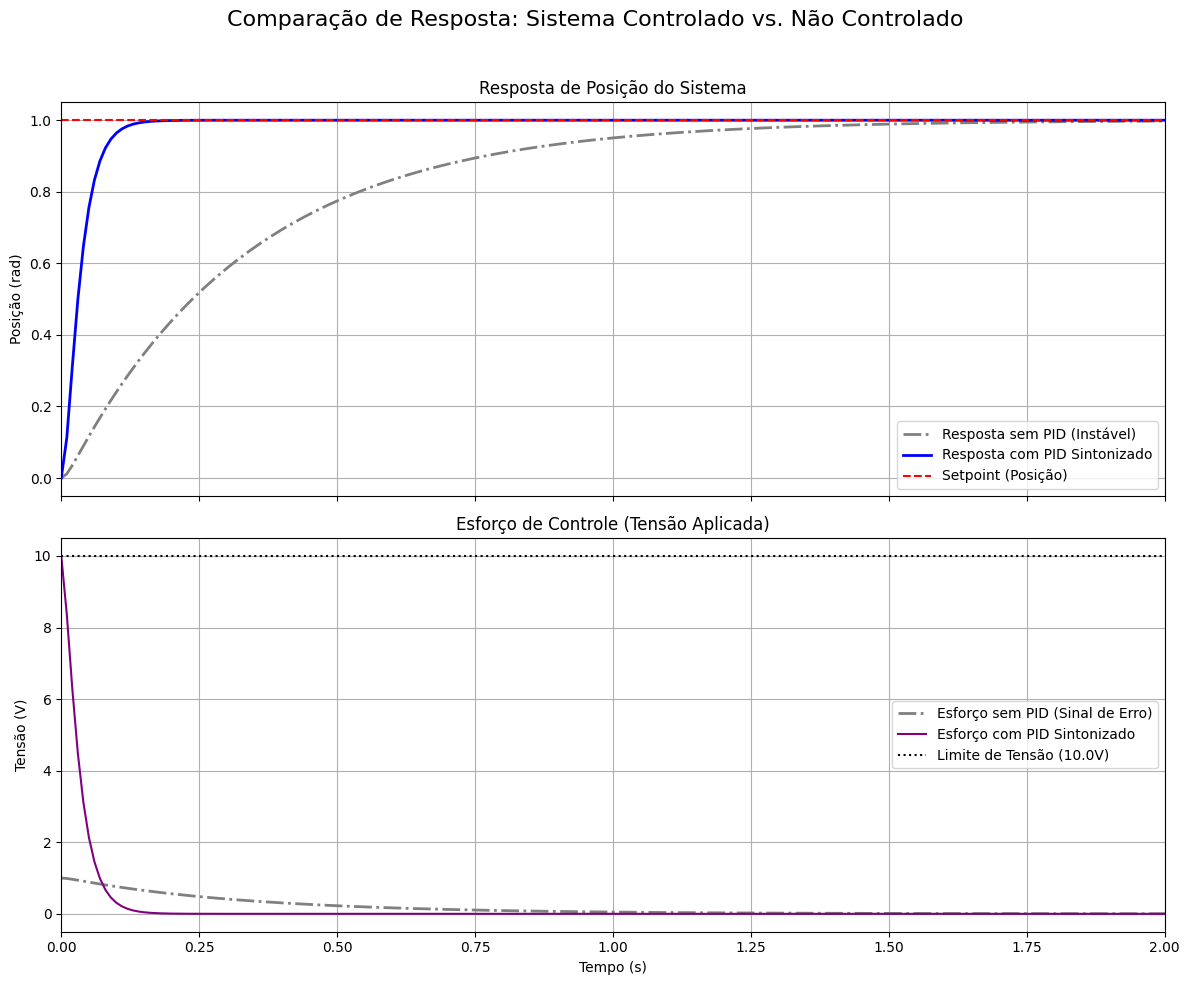

In [ ]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import random
from tabulate import tabulate



def auto_tune_pid(plant, targets, initial_gains, max_iterations=200, print_interval=20, search_scale=0.1):
    """
    Função de sintonia automática para encontrar os ganhos PID com base em múltiplos critérios.
    Com tratamento robusto para respostas que não acomodam no tempo de simulação.
    """
    print("\n" + "="*60)
    print("INICIANDO SINTONIA AUTOMÁTICA DO PID COM RESTRIÇÕES")
    print("="*60)
    print(f"Objetivos: Overshoot <= {targets['overshoot']:.2f}% | "
          f"T. Acomodação <= {targets['settling_time']:.2f}s | "
          f"Pico de Esforço <= {targets['control_effort']:.2f}V")
    
    best_gains = initial_gains
    best_cost = float('inf')

    # Pesos para a função de custo (agora com peso maior para o tempo de acomodação)
    w_overshoot = 1.0     
    w_settling = 1.5      # Aumentado para priorizar a acomodação
    w_effort = 3.0        
    
    # Define um tempo de simulação LONGO e FIXO para o tuner
    sim_time_tuner = max(15.0, 4 * targets['settling_time'])
    time_vector_tuner = np.linspace(0, sim_time_tuner, 1500) # Mais pontos para precisão
    print(f"(Simulando cada iteração por {sim_time_tuner:.1f}s para avaliar a acomodação)")

    for i in range(max_iterations):
        # Gera novos ganhos
        current_search_scale = search_scale * (1 - (i / max_iterations)**2)
        
        kp_try = best_gains[0] + random.uniform(-current_search_scale * best_gains[0], current_search_scale * best_gains[0])
        ki_try = best_gains[1] + random.uniform(-current_search_scale * best_gains[1], current_search_scale * best_gains[1])
        kd_try = best_gains[2] + random.uniform(-current_search_scale * best_gains[2], current_search_scale * best_gains[2])

        kp_try, ki_try, kd_try = max(1e-6, kp_try), max(1e-6, ki_try), max(1e-6, kd_try)
        
        # Cria controlador PID realizável
        Tf = 0.01 
        C_pid = ct.tf([kd_try + kp_try*Tf, kp_try + ki_try*Tf, ki_try], [Tf, 1, 0])
        
        System_CL = ct.feedback(C_pid * plant, 1)
        TF_esforco = C_pid / (1 + C_pid * plant)

        try:
            info = ct.step_info(System_CL, T=time_vector_tuner)
            _, u_try = ct.step_response(TF_esforco, T=time_vector_tuner)

            # --- Lógica de Custo com Penalidade para NaN ---
            # Penaliza fortemente se o sistema não acomodar no tempo de simulação
            if np.isnan(info['SettlingTime']):
                settling_error = 1000  # Valor de penalidade muito alto
            else:
                settling_error = max(0, info['SettlingTime'] - targets['settling_time'])

            overshoot_error = max(0, info['Overshoot'] - targets['overshoot'])
            effort_error = max(0, np.max(u_try) - targets['control_effort'])
            
            # Função de custo: Penaliza o quadrado dos erros para dar mais peso a grandes desvios
            cost = (w_overshoot * overshoot_error**2) + (w_settling * settling_error) + (w_effort * effort_error**2)
            
            if cost < best_cost:
                best_cost = cost
                best_gains = (kp_try, ki_try, kd_try)

            if i % print_interval == 0:
                settling_time_str = f"{info['SettlingTime']:.3f}s" if not np.isnan(info['SettlingTime']) else "nan"
                print(f"It {i:4d}: Custo={best_cost:.4f} -> "
                      f"Kp={best_gains[0]:.3f}, Ki={best_gains[1]:.3f}, Kd={best_gains[2]:.3f} | "
                      f"Overshoot={info['Overshoot']:.2f}%, T_ac={settling_time_str}, Pico U={np.max(u_try):.2f}V")
        
        except (ValueError, IndexError):
            continue 
            
    print("\nSintonia Concluída!")
    print("-" * 50)
    return best_gains

# --- SCRIPT PRINCIPAL ---
if __name__ == '__main__':
    # 1. Parâmetros da Planta

    s = ct.tf('s')
    G_pos = K_motor_rad_v / (s * (tau_final_com_carga * s + 1))
    
    # 2. Definição dos Critérios de Desempenho
    performance_targets = {
        'overshoot': 0.0,         
        'settling_time': 1.0,     # Aumentado um pouco o alvo para dar mais liberdade ao otimizador
        'control_effort': 10.0    
    }

    # 3. Ganhos Iniciais para a Busca
    initial_Kp = 0.8
    initial_Ki = 0.1
    initial_Kd = 7.0 
    
    # 4. Executa a Função de Auto-Tuning
    melhores_ganhos = auto_tune_pid(
        plant=G_pos,
        targets=performance_targets,
        initial_gains=(initial_Kp, initial_Ki, initial_Kd),
        max_iterations=1000, 
        print_interval=100,
        search_scale=0.25
    )
    
    Kp_final, Ki_final, Kd_final = melhores_ganhos
    
    print("\n" + "="*50)
    print("RESULTADO FINAL DA SINTONIA")
    print("="*50)
    print(f"Melhores Ganhos Encontrados:")
    print(f"  Kp = {Kp_final:.4f}")
    print(f"  Ki = {Ki_final:.4f}")
    print(f"  Kd = {Kd_final:.4f}")

    # --- 5. Simula e Plota a Resposta Final ---
    # Cria um vetor de tempo único para todas as simulações
    final_plot_time = max(15.0, 1.5 * performance_targets['settling_time']) 
    time_vector = np.linspace(0, final_plot_time, 1500)

    # --- Sistema com PID Sintonizado ---
    # Controlador PID com os melhores ganhos encontrados
    Tf = 0.01
    num_pid_final = [Kd_final + Kp_final * Tf, Kp_final + Ki_final * Tf, Ki_final]
    den_pid_final = [Tf, 1, 0]
    C_pid_final = ct.tf(num_pid_final, den_pid_final)

    # Sistema em malha fechada para a RESPOSTA DE POSIÇÃO com PID
    Sistema_MF_final = ct.feedback(C_pid_final * G_pos, 1)
    t_final, y_final = ct.step_response(Sistema_MF_final, T=time_vector)

    # Sistema em malha fechada para o ESFORÇO DE CONTROLE com PID
    TF_esforco_final = C_pid_final / (1 + C_pid_final * G_pos)
    t_esforco, u_final = ct.step_response(TF_esforco_final, T=time_vector)

    # --- Sistema NÃO CONTROLADO (planta em malha fechada simples) ---
    # Sistema em malha fechada para a RESPOSTA DE POSIÇÃO sem PID
    Sistema_MF_inicial = ct.feedback(G_pos, 1)
    t_inicial, y_inicial = ct.step_response(Sistema_MF_inicial, T=time_vector)

    # Sistema em malha fechada para o ESFORÇO DE CONTROLE sem PID
    # Neste caso, o "esforço" é o próprio sinal de erro: U(s)/R(s) = 1 / (1 + G(s))
    TF_esforco_inicial = 1 / (1 + G_pos)
    t_esforco_inicial, u_inicial = ct.step_response(TF_esforco_inicial, T=time_vector)


    # Calcula as informações de performance para a resposta com PID
    info_final = ct.step_info(Sistema_MF_final, T=time_vector)

    print("\nPerformance do Controlador Sintonizado:")
    settling_time_final_str = f"{info_final['SettlingTime']:.3f} s" if not np.isnan(info_final['SettlingTime']) else "Não acomodou no tempo de plot."
    print(f"  - Overshoot: {info_final['Overshoot']:.2f}%")
    print(f"  - Tempo de Acomodação (2%): {settling_time_final_str}")
    print(f"  - Pico do Esforço de Controle: {np.max(u_final):.2f} V")


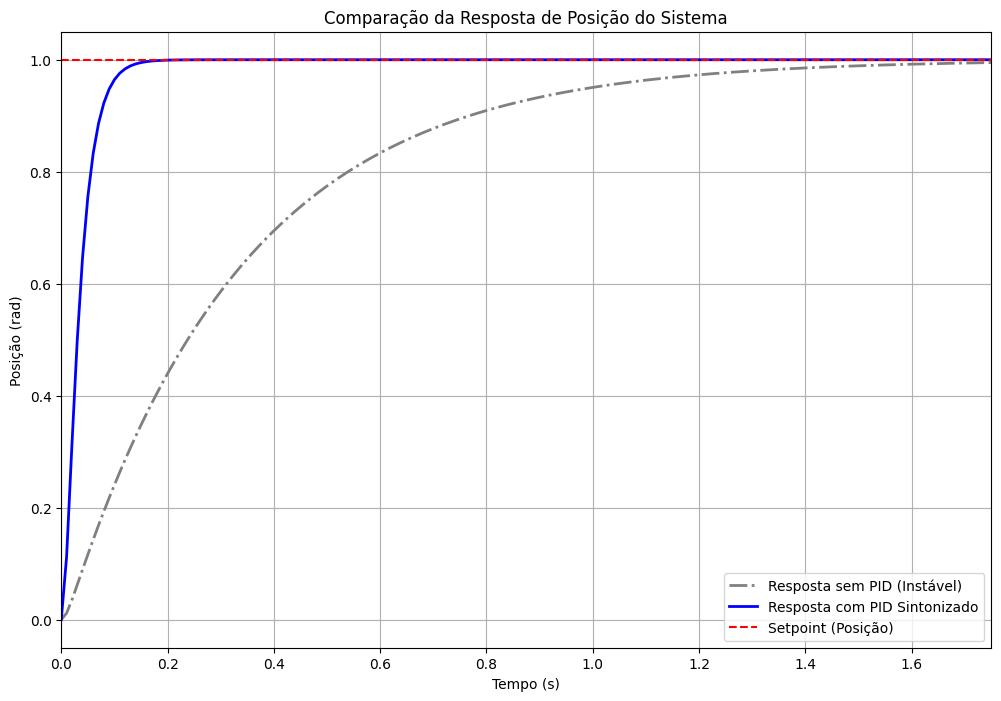

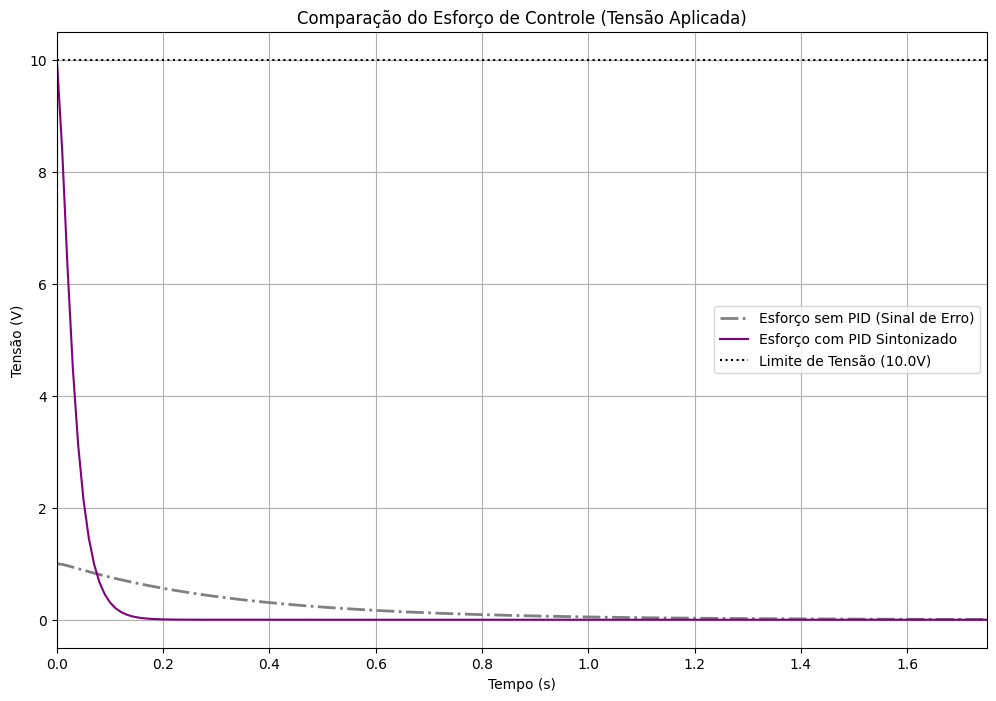

In [12]:
# --- Figura 1: Resposta de Posição ---
plt.figure(1, figsize=(12, 8)) # Cria a Figura 1
plt.plot(t_inicial, y_inicial, label='Resposta sem PID (Instável)', linewidth=2, linestyle='-.', color='grey')
plt.plot(t_final, y_final, label='Resposta com PID Sintonizado', linewidth=2, color='blue')
plt.axhline(y=1.0, color='r', linestyle='--', label='Setpoint (Posição)')
plt.title('Comparação da Resposta de Posição do Sistema')
plt.xlabel("Tempo (s)")
plt.ylabel("Posição (rad)")
plt.grid(True)
plt.legend()
plt.xlim(0, 1.75) # Ajusta o limite do eixo X

# --- Figura 2: Esforço de Controle ---
plt.figure(2, figsize=(12, 8)) # Cria a Figura 2
plt.plot(t_esforco_inicial, u_inicial, label='Esforço sem PID (Sinal de Erro)', linewidth=2, linestyle='-.', color='grey')
plt.plot(t_esforco, u_final, label='Esforço com PID Sintonizado', color='purple')
plt.axhline(y=performance_targets['control_effort'], color='k', linestyle=':', label=f'Limite de Tensão ({performance_targets["control_effort"]}V)')
plt.title('Comparação do Esforço de Controle (Tensão Aplicada)')
plt.xlabel("Tempo (s)")
plt.ylabel("Tensão (V)")
plt.grid(True)
plt.legend()
plt.xlim(0, 1.75) # Ajusta o limite do eixo X

# Mostra todas as figuras que foram criadas
plt.show()

# Lugar das raízes

In [6]:
# import numpy as np
# import control as co_general
# import matplotlib.pyplot as plt
# import control.matlab as co

# %matplotlib qt


# Gw = G_pos
# # Polos e zeros de Gtheta(s)
# print('Polos da planta Gw(s) = ', co.pole(Gw))
# print('Zeros da planta Gw(s) = ', co.zero(Gw))
# # Definicao do controlador PI, Inicialmente Kp=1
# Ti = tau_total_com_carga
# Kp = 1
# # Definicao da Funcao de Transferencia de Malha Fechada

# Hw = Kp*(1+ 1/(Ti*s))   

# print(Hw)
# # Funcao de Transferencia de Malha Aberta
# GHw=Gw*Hw
# print('FT DE MALHA ABERTA GHw(s)=Gw(s)*Hw(s) = ')
# print(GHw)
# [rlist,klist]=co.rlocus(GHw,plot=True,grid=True)


-------------
FT da planta Gw(s) = 
<TransferFunction>: sys[25]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


     2.953
----------------
0.008889 s^2 + s

-------------
FT DE MALHA ABERTA GHw(s)=Gw(s)*Hw(s) = 
<TransferFunction>: sys[10045]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.2953 s^2 + 28.34 s + 9.072e-06
---------------------------------
8.889e-05 s^4 + 0.01889 s^3 + s^2

-------------
POLOS E ZEROS DE MALHA ABERTA
Polos de GHw(s) =  [-112.49731945+0.j -100.        +0.j    0.        +0.j    0.        +0.j]
Zeros de GHw(s) =  [-9.59599174e+01+0.j -3.20147139e-07+0.j]
-------------
FT DE MALHA FECHADA GHw(s)/(1+GHw(s))
<TransferFunction>: sys[10047]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


              0.2953 s^2 + 28.34 s + 9.072e-06
-------------------------------------------------------------
8.889e-05 s^4 + 0.01889 s^3 + 1.295 s^2 + 28.34 s + 9.072e-06

-------------
POLOS E ZEROS DE MALHA FECHADA
Polos da planta cloop(s) =  GHw(s)/(1+GHw(s)) =  [-8.92247515e+01+0.j

c:\Users\Fefon\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\timeresp.py:1691: RuntimeWarning: divide by zero encountered in divide
  np.abs(yout/InfValue - 1) >= SettlingTimeThreshold)[0]


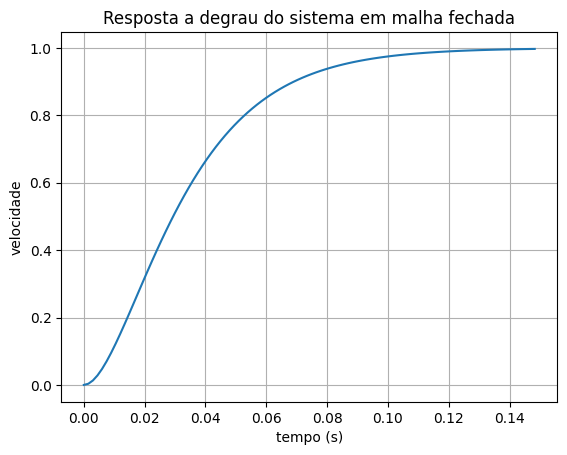

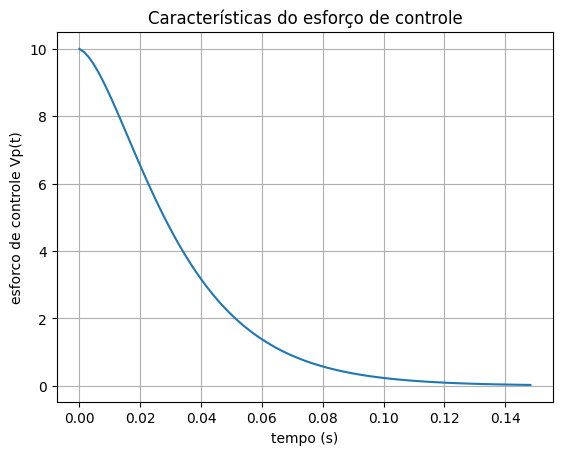

-------------
FT DE MALHA FECHADA GH(s)/(1+GH(s))
<TransferFunction>: sys[10058]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


              0.2953 s^2 + 28.34 s + 9.072e-06
-------------------------------------------------------------
8.889e-05 s^4 + 0.01889 s^3 + 1.295 s^2 + 28.34 s + 9.072e-06

-------------
POLOS E ZEROS DE MALHA FECHADA
Polos da planta cloop(s) =  GH(s)/(1+GH(s)) =  [-8.92247515e+01+0.j -7.66760571e+01+0.j -4.65965106e+01+0.j
 -3.20147143e-07+0.j]
Zeros da planta cloop(s) =  GH(s)/(1+GH(s)) =  [-9.59599174e+01+0.j -3.20147139e-07+0.j]
-------------
COEF. DE AMORTECIMENTO E FREQ. NATURAL
_____Polos____________zeta_______omegan
    Eigenvalue (pole)       Damping     Frequency
               -89.22             1         89.22
               -76.68             1         76.68
                -46.6             1          46.6
           -3.201e-07             1     3.201e-07
-------------
CARACTERISTICAS DA RESPOSTA TRANSITORIA DO SISTEMA
tempo de subida tr =  0.06 seg

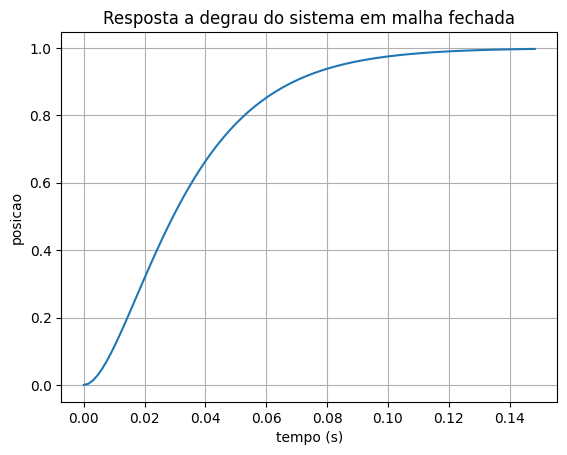

In [7]:
# Python packages
import numpy as np
import control as co_general
import control.matlab as co
import matplotlib.pyplot as plt

%matplotlib inline

# Definicao de s como funcao de transferencia
s = co.tf('s')
Gw = G_pos
print('-------------')
print('FT da planta Gw(s) = ')
print(Gw)
# Controlador Hw(s)
Hw = C_pid_final

# Malha aberta
GHw=Gw*Hw
print('-------------')
print('FT DE MALHA ABERTA GHw(s)=Gw(s)*Hw(s) = ')
print(GHw)
print('-------------')
print('POLOS E ZEROS DE MALHA ABERTA')
print('Polos de GHw(s) = ', co.pole(GHw))
print('Zeros de GHw(s) = ', co.zero(GHw))
# Funcao de transferencia em malha fechada
cloop = co.feedback(GHw,1)
print('-------------')
print('FT DE MALHA FECHADA GHw(s)/(1+GHw(s))')
print(cloop)
print('-------------')
print('POLOS E ZEROS DE MALHA FECHADA')
print('Polos da planta cloop(s) =  GHw(s)/(1+GHw(s)) = ', co.pole(cloop))
print('Zeros da planta cloop(s) =  GHw(s)/(1+GHw(s)) = ', co.zero(cloop))
print('-------------')
print('COEF. DE AMORTECIMENTO E FREQ. NATURAL')
print('_____Polos____________zeta_______omegan')
co.damp(cloop)
# Calcula as caracteristicas da resposta transitoria
#  stepinfo(sys, T=None, SettlingTimeThreshold=0.02, RiseTimeLimits=(0.1,0.9))
#  S: a dictionary containing:
#        RiseTime: Time from 10% to 90% of the steady-state value.
#        SettlingTime: Time to enter inside a default error of 2%
#        SettlingMin: Minimum value after RiseTime
#        SettlingMax: Maximum value after RiseTime
#        Overshoot: Percentage of the Peak relative to steady value
#        Undershoot: Percentage of undershoot
#        Peak: Absolute peak value
#        PeakTime: time of the Peak
#        SteadyStateValue: Steady-state value
S=co.stepinfo(cloop)
print('-------------')
print('CARACTERISTICAS DA RESPOSTA TRANSITORIA DO SISTEMA')
print('tempo de subida tr = ','%.2f' % S['RiseTime'],'seg')
print('tempo de acomodacao ts = ','%.2f' % S['SettlingTime'],'seg')
print('maximo sobresinal Mp = ',S['Overshoot'])
print('valor de pico thetaomax = ','%.2f' % S['Peak'])
print('instante de pico tp = ','%.2f' % S['PeakTime'],'seg')
print('valor de regime estacionario thetaoss = ','%.2f' % S['SteadyStateValue'])
# Grafico da resposta a degrau unitario
plt.figure(3)
wo, t = co.step(cloop)
plt.plot(t,wo)
plt.title('Resposta a degrau do sistema em malha fechada')
plt.xlabel('tempo (s)')
plt.ylabel('velocidade')
plt.grid()
#
# Esforco de controle
#
# Funcao de transferencia para calculo do esforco de controle u(t)
# o sinal u(t) pode ser calculado definindo-se
# um sistema de controle em malha fechada onde H(s)
# esta na malha direta e G(s) na malha de realimentacao
#
# R(s)  E(s)|------|        U(s)
#---->(+)---| H(s) |------------>
#    _ ^    |------|    |
#      |                |
#      |    |------|    |
#      |----| G(s) |<----
#           |------|
# 
esforco=co.feedback(Hw,Gw)
print('-------------')
print('FT DO ESFORCO DE CONTROLE Hw(s)/(1+Hw(s)Gw(s))')
print(esforco)
# Caracteristicas da resposta transitória
SE=co.stepinfo(esforco)
# Valor de pico
print('-------------')
print('CARACTERISTICAS DO ESFORCO DE CONTROLE')
print('valor de pico Vpmax = ','%.2f' % SE['Peak'])
plt.figure(4)
Vw, te = co.step(esforco)
plt.plot(te, Vw)
plt.title('Características do esforço de controle')
plt.xlabel('tempo (s)')
plt.ylabel('esforco de controle Vp(t)')
plt.grid()
plt.show()

cloop = co.feedback(GHw,1)
print('-------------')
print('FT DE MALHA FECHADA GH(s)/(1+GH(s))')
print(cloop)
print('-------------')
print('POLOS E ZEROS DE MALHA FECHADA')
print('Polos da planta cloop(s) =  GH(s)/(1+GH(s)) = ', co.pole(cloop))
print('Zeros da planta cloop(s) =  GH(s)/(1+GH(s)) = ', co.zero(cloop))
#co.pzmap(cloop,grid=True,title='PZMAP malha fechada')
print('-------------')
print('COEF. DE AMORTECIMENTO E FREQ. NATURAL')
print('_____Polos____________zeta_______omegan')
co.damp(cloop)
# Calcula as caracteristicas da resposta transitoria
#  stepinfo(sys, T=None, SettlingTimeThreshold=0.02, RiseTimeLimits=(0.1,0.9))
#  S: a dictionary containing:
#        RiseTime: Time from 10% to 90% of the steady-state value.
#        SettlingTime: Time to enter inside a default error of 2%
#        SettlingMin: Minimum value after RiseTime
#        SettlingMax: Maximum value after RiseTime
#        Overshoot: Percentage of the Peak relative to steady value
#        Undershoot: Percentage of undershoot
#        Peak: Absolute peak value
#        PeakTime: time of the Peak
#        SteadyStateValue: Steady-state value
S=co.stepinfo(cloop)
print('-------------')
print('CARACTERISTICAS DA RESPOSTA TRANSITORIA DO SISTEMA')
print('tempo de subida tr = ','%.2f' % S['RiseTime'],'seg')
print('tempo de acomodacao ts = ','%.2f' % S['SettlingTime'],'seg')
print('maximo sobresinal Mp = ',S['Overshoot'])
print('valor de pico rmax = ','%.2f' % S['Peak'])
print('instante de pico tp = ','%.2f' % S['PeakTime'],'seg')
print('valor de regime estacionario rss = ','%.2f' % S['SteadyStateValue'])
# Grafico da resposta a degrau unitario
plt.figure(3)
r, t = co.step(cloop)
plt.plot(t,r)
plt.title('Resposta a degrau do sistema em malha fechada')
plt.xlabel('tempo (s)')
plt.ylabel('posicao')
plt.grid()